In [1]:
from pathlib import Path
import numpy as np

from my_types import Vec3, Quat, ScalarBatch
from my_types import as_vec3
from io_csv import load_gyro_base, load_ref, load_acc, load_grav_ref, load_acc_lin_ref
from pipelines import integrate_gyro_acc
from evaluation import calc_angle_err, print_err_status, save_err_csv,plot_err_from_csv, save_estimated_vec3_csv
from evaluation import evaluate_estimated_vec3_autosign

EPS: float = 1e-9

In [2]:
root: Path = Path.cwd().parent
run_dir: Path = root / "data" / "21:08_oct_07_2025_5min"

ori_path: Path = run_dir / "Orientation.csv"
gyro_path: Path = run_dir / "Gyroscope.csv"
grav_path: Path = run_dir / "Gravity.csv"
acc_path: Path = run_dir / "AccelerometerUncalibrated.csv"
acc_lin_path: Path = run_dir / "Accelerometer.csv"

for p in [ori_path, gyro_path, grav_path, acc_path, acc_lin_path]:
        if not p.exists():
                raise FileNotFoundError(f"File not found: {p}")

In [3]:
t_src_gyro, w_src_gyro, dt, t_new, w_avg_gyro = load_gyro_base(gyro_path)

q_ref_interp = load_ref(ori_path, t_new)
q_ref_interp /= np.linalg.norm(q_ref_interp, axis=1, keepdims=True)

a_src_interp = load_acc(acc_path, t_new)

In [4]:
q0: Quat = q_ref_interp[0].copy()
K: float = 0.05
g0: float = 9.80665
gate_sigma: float = 1.2
g_world_unit: Vec3 = as_vec3(np.array([0, 0, -1]))
q_gyro_acc, g_body_est, a_lin_est = integrate_gyro_acc(q0, w_avg_gyro, dt,
                                                       K, g0, g_world_unit, gate_sigma, a_src_interp)

angle_err_gyro_acc: ScalarBatch = calc_angle_err(q_gyro_acc, q_ref_interp)
print_err_status("Gyro + Acc", angle_err_gyro_acc)

Gyro + Acc angle error in rad — min/max/mean
0.0011642279743390399 1.0182785895290674 0.20244243085556612

Gyro + Acc angle error in deg — min/max/mean
0.0667053493206921 58.3430655485499 11.59909688239293


In [5]:
out_dir: Path = root / "output"
out_dir.mkdir(parents=True, exist_ok=True)
out_path: Path = out_dir / "03_angle_err_gyro_acc.csv"
save_err_csv(out_path, t_new, angle_err_gyro_acc)

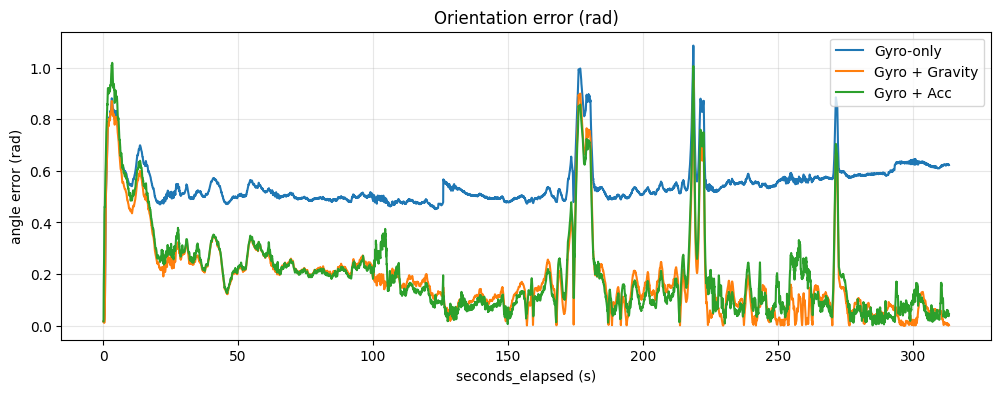

In [6]:
out_gyro_path = out_dir / "01_angle_err_gyro.csv"
out_grav_path = out_dir / "02_angle_err_gyro_grav.csv"
out_acc_path = out_dir / "03_angle_err_gyro_acc.csv"

plot_err_from_csv([
        ("Gyro-only", out_gyro_path),
        ("Gyro + Gravity", out_grav_path),
        ("Gyro + Acc", out_acc_path)
])

In [7]:
print("Gravity:")
g_ref_interp = load_grav_ref(grav_path, t_new)
g_est_sign_fixed, g_rmse_norm = evaluate_estimated_vec3_autosign(g_body_est, g_ref_interp)
print("")

print("Linear Acc:")
a_lin_ref_interp = load_acc_lin_ref(acc_lin_path, t_new)
a_lin_est_sign_fixed, a_lin_rmse_norm = evaluate_estimated_vec3_autosign(a_lin_est, a_lin_ref_interp)
print("")

save_estimated_vec3_csv(out_dir / "gravity_estimated.csv", t_new, g_est_sign_fixed)
save_estimated_vec3_csv(out_dir / "linear_acc_estimated.csv", t_new, a_lin_est_sign_fixed)

print("consistency ratio (a_lin / g):", a_lin_rmse_norm / max(g_rmse_norm, EPS))

Gravity:
RMSE norm: 0.9199042943808741

Linear Acc:
RMSE norm: 1.1817736092341402

consistency ratio (a_lin / g): 1.2846701732483081
